R 스크립트가 보기 좋지 않아 jupyter notebook에 r kernel을 연결하여 다시 작성했습니다
보고서와 약간 코드가 다를 수 있습니다

In [1]:
library(moments)
library(dplyr)
library(ggplot2)
library(corrplot)
library(MVN)
library(randomForest)
library(caret)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


corrplot 0.84 loaded

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

sROC 0.1-2 loaded

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Loading required package: lattice



 Performance evaluation function for regression

In [2]:
perf_eval_reg <- function(tgt_y, pre_y){
  # RMSE
  rmse <- sqrt(mean((tgt_y - pre_y)^2))
  # MAE
  mae <- mean(abs(tgt_y - pre_y))
  # MAPE
  mape <- 100*mean(abs((tgt_y - pre_y)/tgt_y))
  return(c(rmse, mae, mape))
}

#  Data Preprocessing

In [3]:
data <- read.csv("insurance.csv")

In [4]:
which(is.na(data))

integer(0)

data 안에 null값이 없다

In [5]:
str(data)

'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : chr  "female" "male" "male" "male" ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : chr  "yes" "no" "no" "no" ...
 $ region  : chr  "southwest" "southeast" "southeast" "northwest" ...
 $ charges : num  16885 1726 4449 21984 3867 ...


sex, smoker 는 값을 0,1로 바꿔주고
region은 southeast southwest northeast 로 컬럼을 추가할 것이다

mlr를 위한 데이터 전처리 
1. sex 를 male -> 0, female -> 1
2. smoker를 yes -> 1, no -> 0
3. southeast southwest northeast를 위한 컬럼 추가

In [6]:
# sex data preprocession
dummy_sex <- rep(0,nrow(data))
dummy_sex[grep("female",data$sex)]<-1

# smoker data preprocession
dummy_smoker <- rep(0,nrow(data))
dummy_smoker[grep("yes",data$smoker)]<-1

# region data proprecessing
dummy_r_southeast = rep(0,nrow(data))
dummy_r_northeast = rep(0,nrow(data))
dummy_r_southwest = rep(0,nrow(data))

southeast_idx <- grep("southeast",data$region)
northeast_idx <- grep("northeast",data$region)
southwest_idx <- grep("southwest",data$region)

dummy_r_southeast[southeast_idx] <-1
dummy_r_northeast[northeast_idx] <-1
dummy_r_southwest[southwest_idx] <-1

# sum up
df <- data.frame(dummy_sex,dummy_smoker,dummy_r_southeast,dummy_r_southwest,dummy_r_northeast)
str(df)
names(df)<-c("sex","smoker","southeast","southwest","northeast")

colnames(data)
# 이중에서 age, bmi, children만 가져올것 : 
id_idx = c(2,5,6) # 버릴 행

# Prepare the data for MLR
mlr_data <- cbind(data[,-c(id_idx)],df)
str(mlr_data)
nr = nrow(data)

'data.frame':	1338 obs. of  5 variables:
 $ dummy_sex        : num  1 0 0 0 0 1 1 1 0 1 ...
 $ dummy_smoker     : num  1 0 0 0 0 0 0 0 0 0 ...
 $ dummy_r_southeast: num  0 1 1 0 0 1 1 0 0 0 ...
 $ dummy_r_southwest: num  1 0 0 0 0 0 0 0 0 0 ...
 $ dummy_r_northeast: num  0 0 0 0 0 0 0 0 1 0 ...


[1] "age"      "sex"      "bmi"      "children" "smoker"   "region"   "charges"

'data.frame':	1338 obs. of  9 variables:
 $ age      : int  19 18 28 33 32 31 46 37 37 60 ...
 $ bmi      : num  27.9 33.8 33 22.7 28.9 ...
 $ children : int  0 1 3 0 0 0 1 3 2 0 ...
 $ charges  : num  16885 1726 4449 21984 3867 ...
 $ sex      : num  1 0 0 0 0 1 1 1 0 1 ...
 $ smoker   : num  1 0 0 0 0 0 0 0 0 0 ...
 $ southeast: num  0 1 1 0 0 1 1 0 0 0 ...
 $ southwest: num  1 0 0 0 0 0 0 0 0 0 ...
 $ northeast: num  0 0 0 0 0 0 0 0 1 0 ...


train / test dataset으로 분리

In [7]:
set.seed(12345) 
trn_idx <- sample(1:nr, round(0.7*nr))
trn_data <- mlr_data[trn_idx,]
val_data <- mlr_data[-trn_idx,]

# EDA 

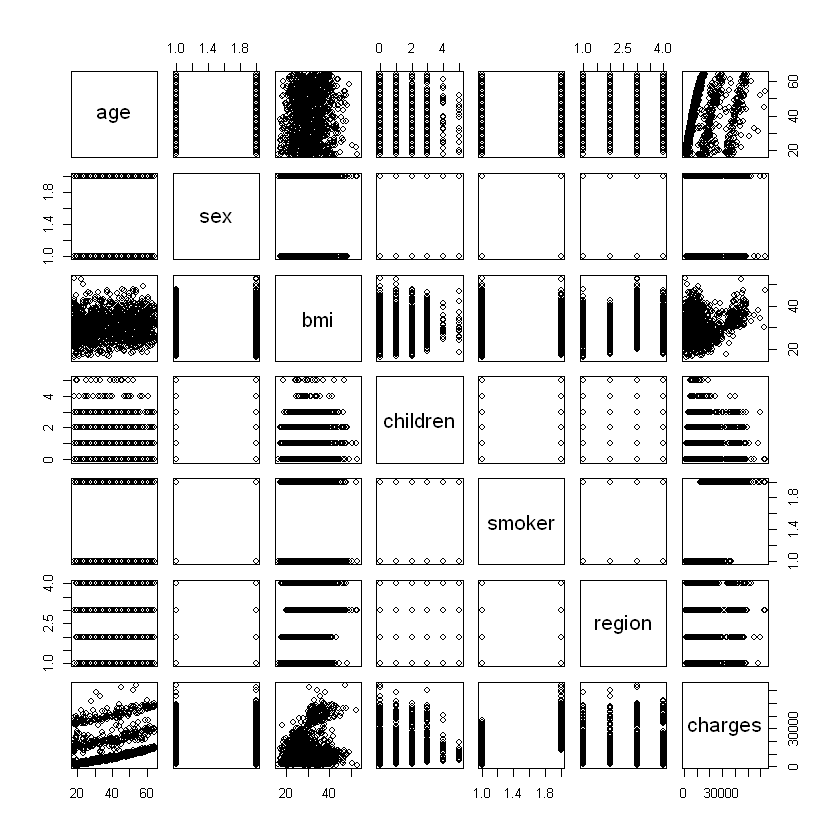

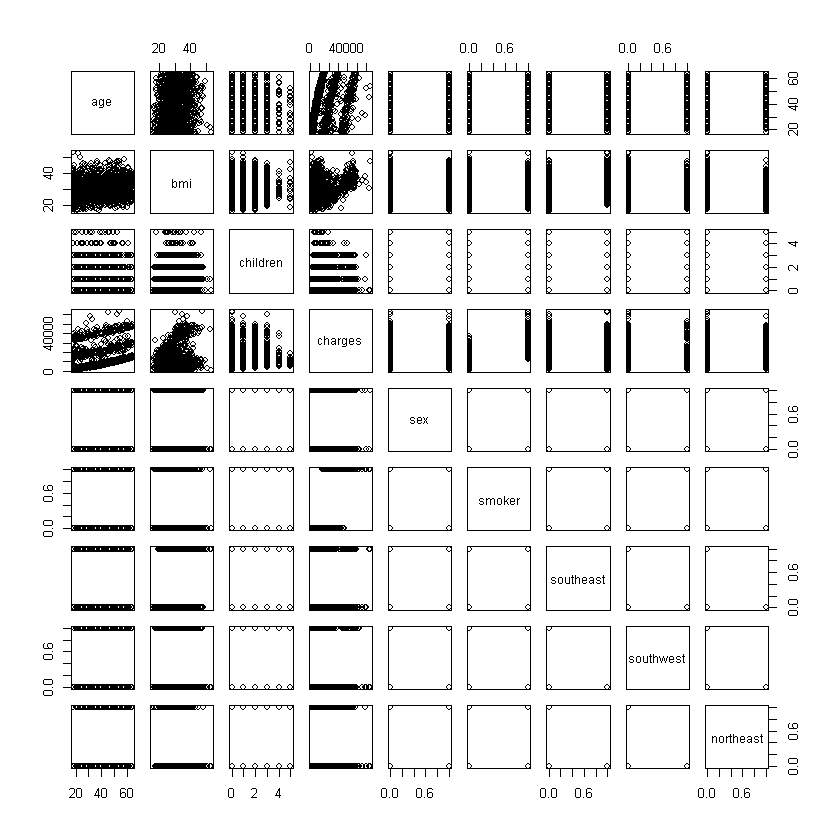

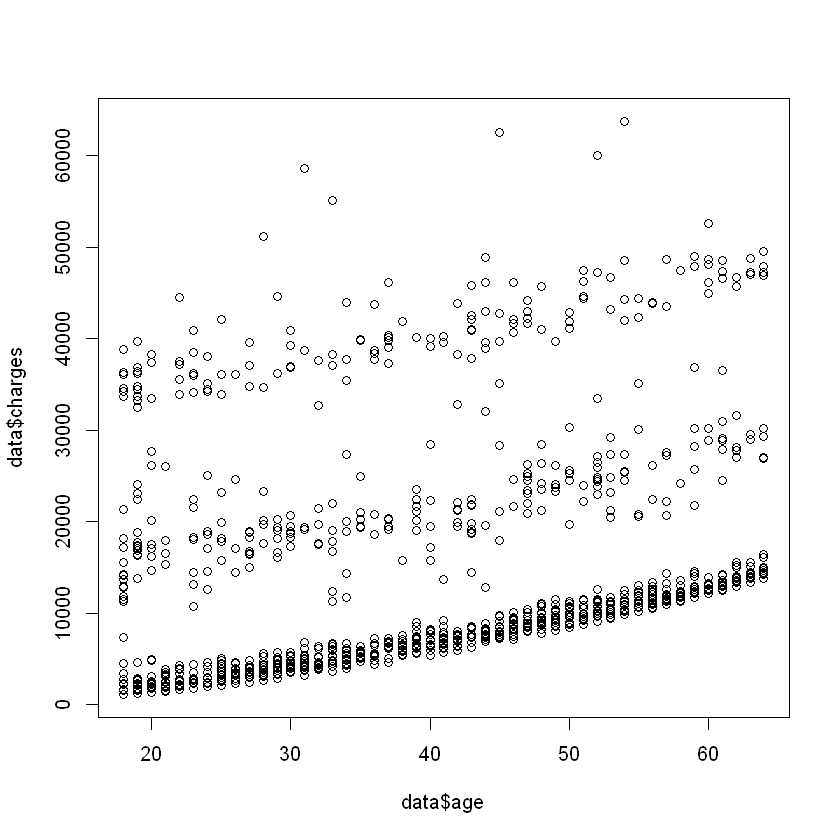

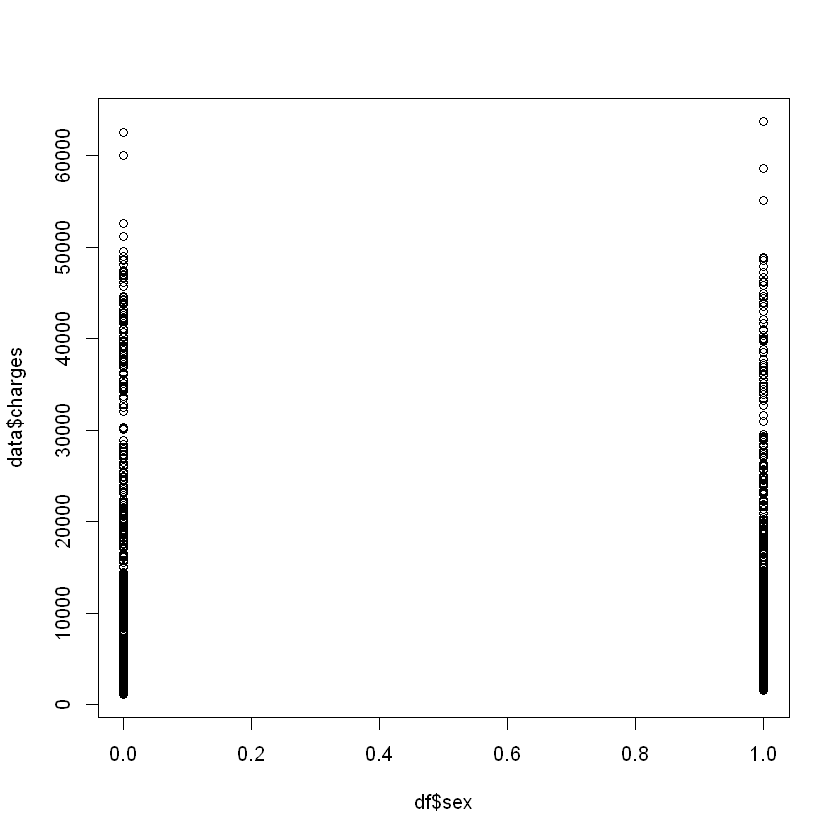

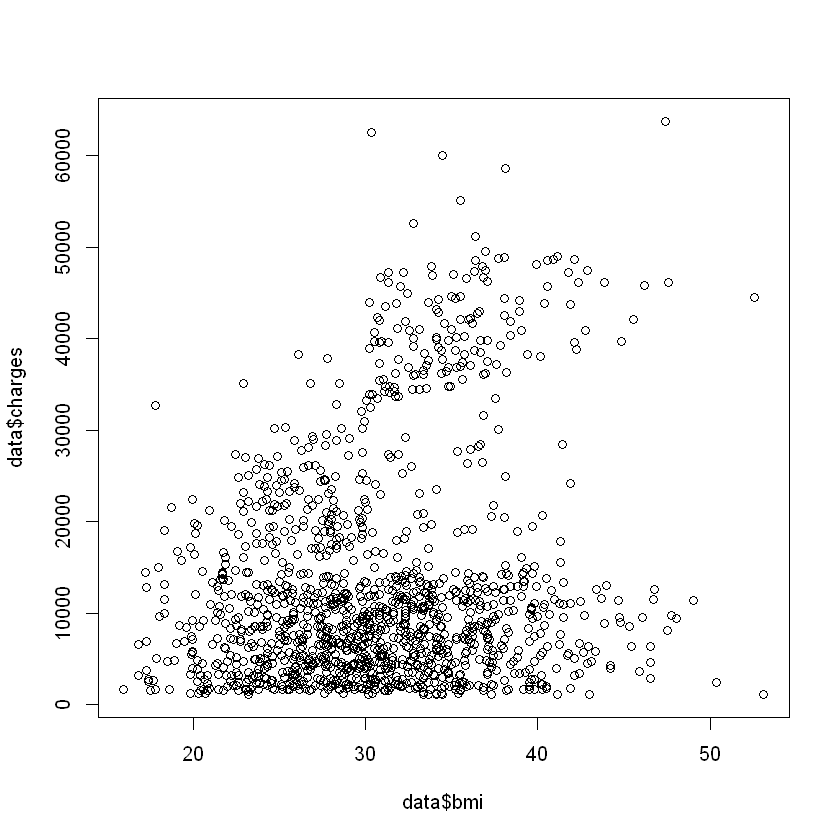

In [8]:
plot(data)
plot(mlr_data)
plot(data$age,data$charges)
plot(df$sex,data$charges)
plot(data$bmi,data$charges)

전처리 전 데이터 & categorical data

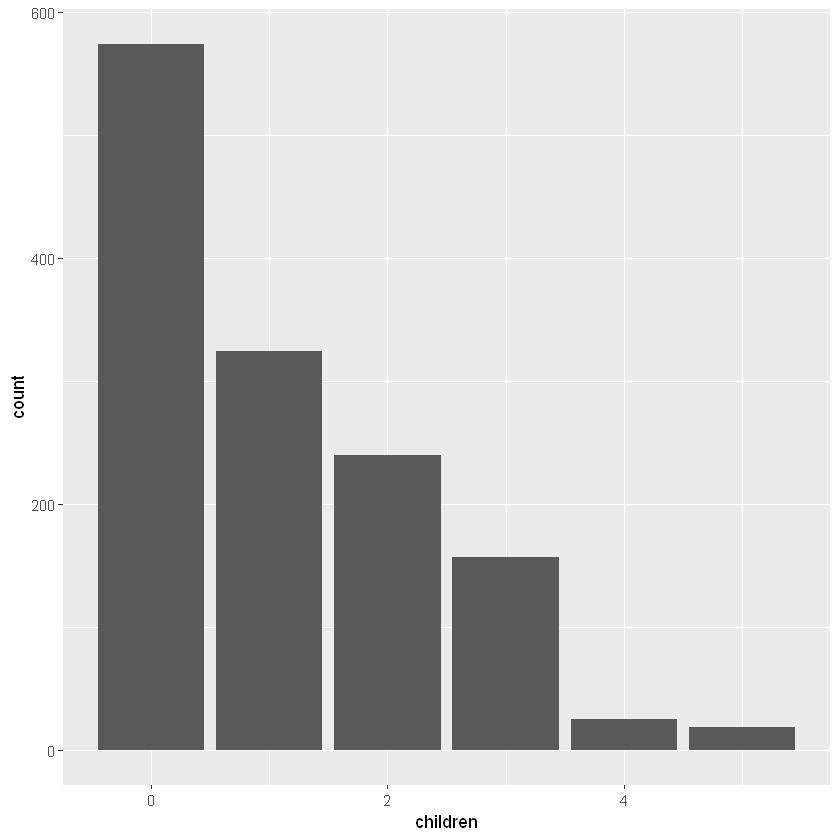

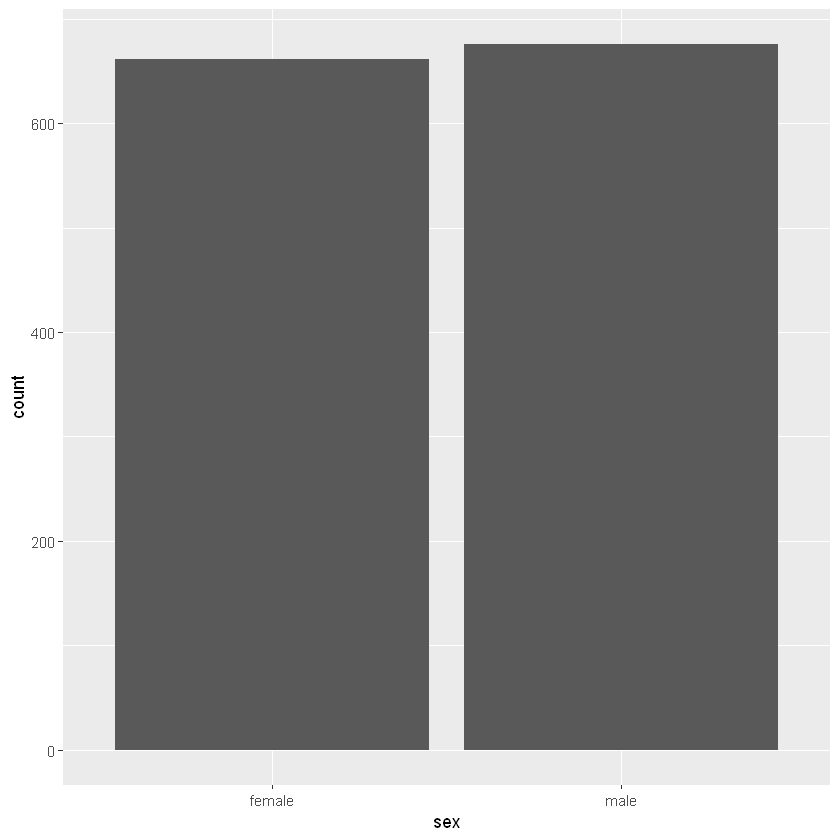

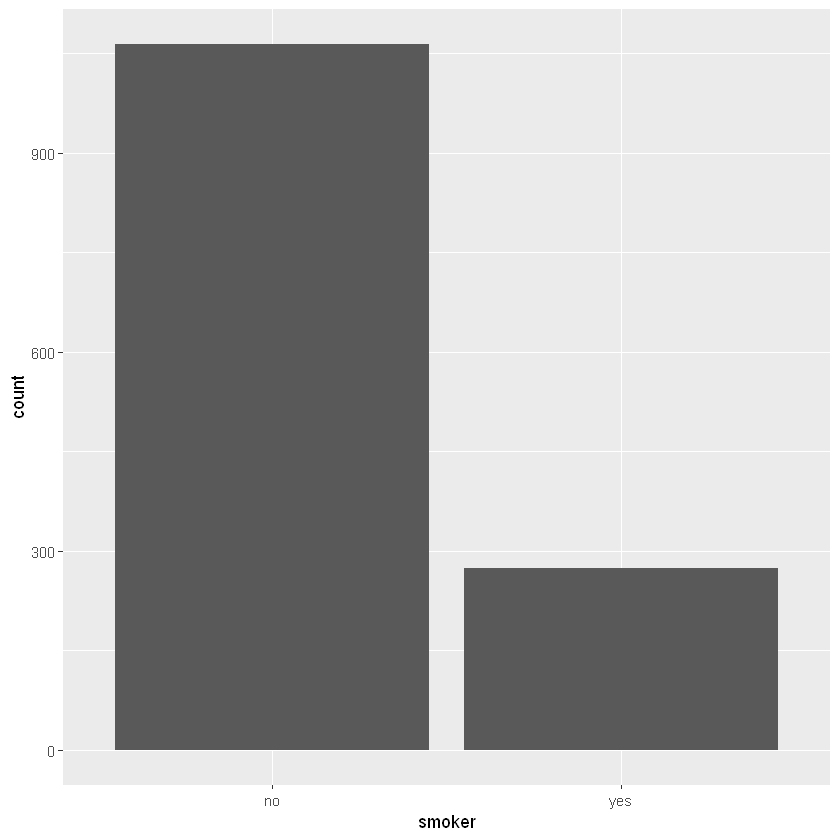

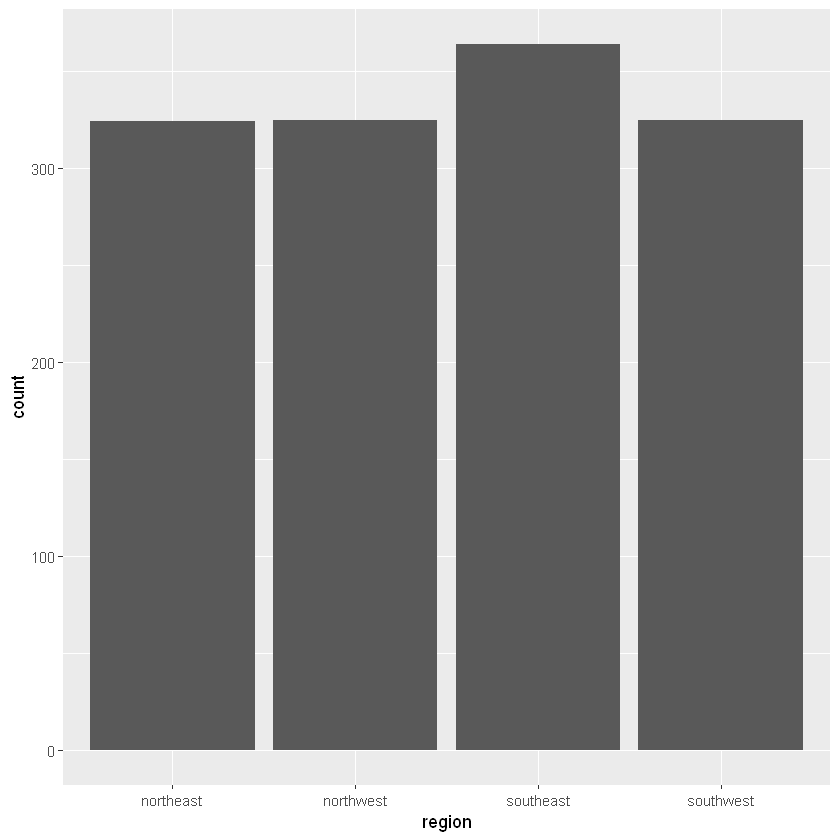

In [9]:
# children
ggplot(data= data)+
  geom_bar(mapping=aes(x=children))
# sex
ggplot(data= data)+
  geom_bar(mapping=aes(x=sex))
# smoker
ggplot(data= data)+
  geom_bar(mapping=aes(x=smoker))
# region
ggplot(data= data)+
  geom_bar(mapping=aes(x=region))

In [10]:
table(data$children)
table(data$sex)
table(data$smoker)
table(data$region)


  0   1   2   3   4   5 
574 324 240 157  25  18 


female   male 
   662    676 


  no  yes 
1064  274 


northeast northwest southeast southwest 
      324       325       364       325 

continuous data

[1] "data %>%\n  count(cut_width(age,5))\n"

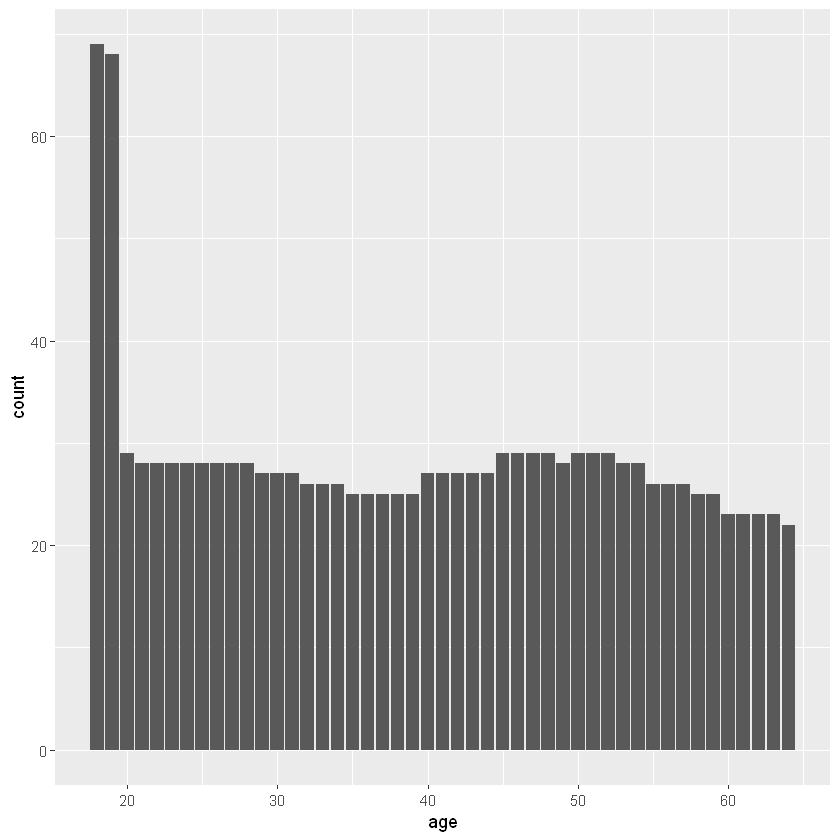

[1] "data %>%\n  count(cut_width(bmi,5))"

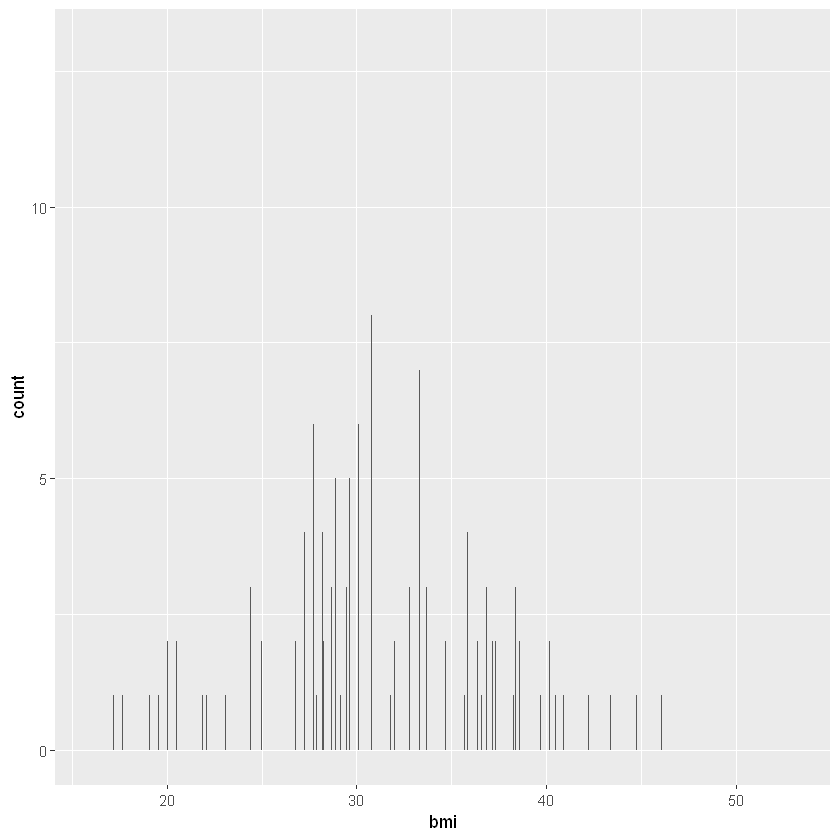

In [11]:
# age
ggplot(data= data)+
  geom_bar(mapping=aes(x=age))

'data %>%
  count(cut_width(age,5))
'
# bmi --> normal disturibution ?
ggplot(data= data)+
  geom_bar(mapping=aes(x=bmi))

'data %>%
  count(cut_width(bmi,5))'

age는 정말로 정규분포가 아니고, bmi는 정규분포 일 수도 있음


boxplot

Warning message:
"Continuous x aesthetic -- did you forget aes(group=...)?"


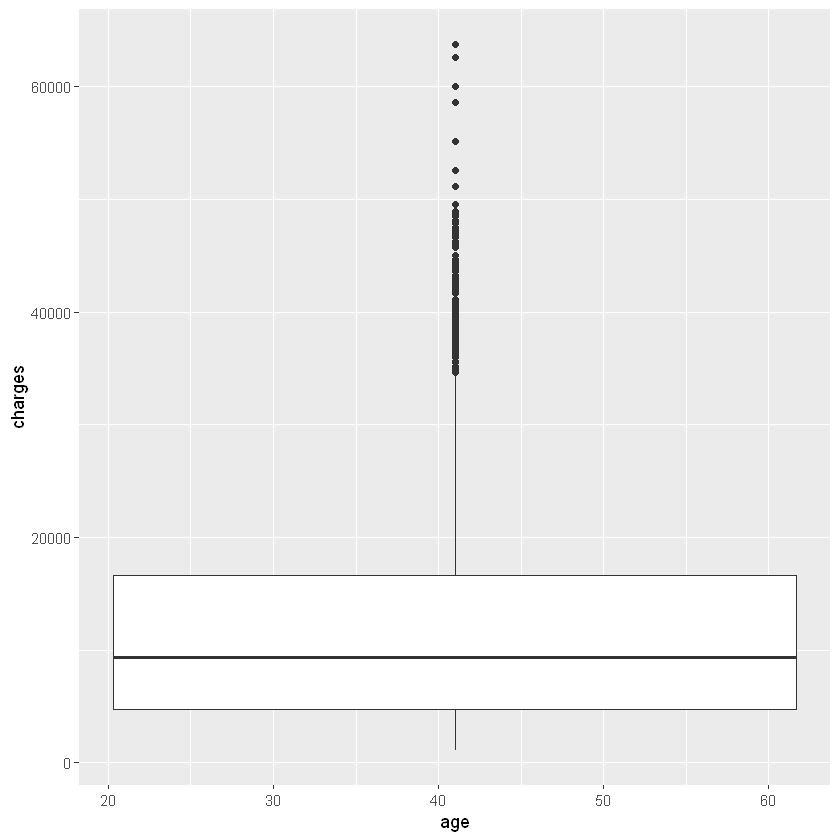

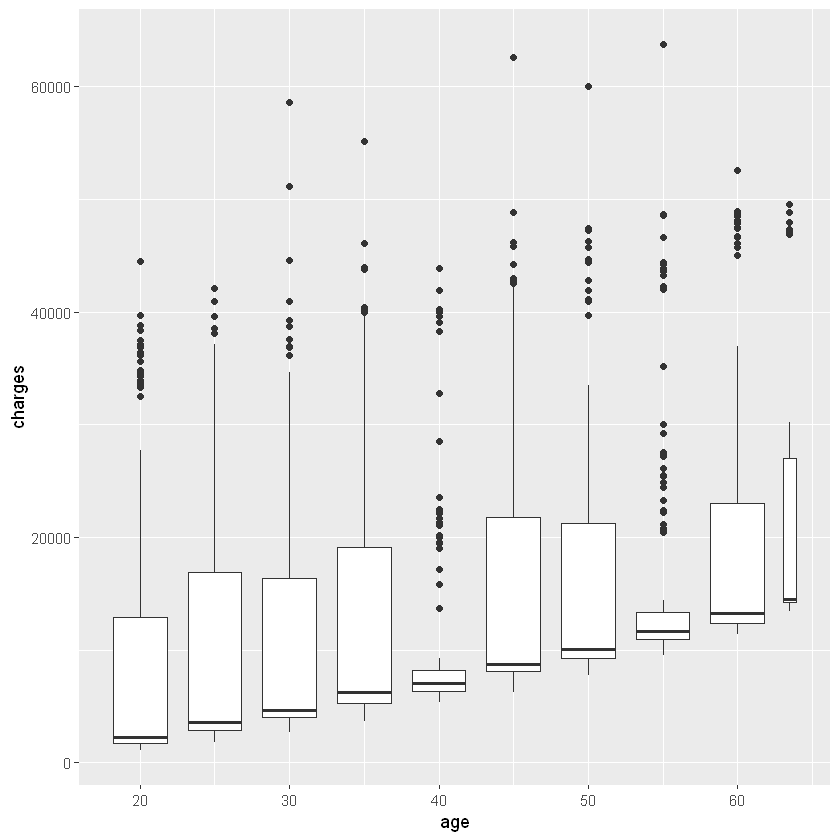

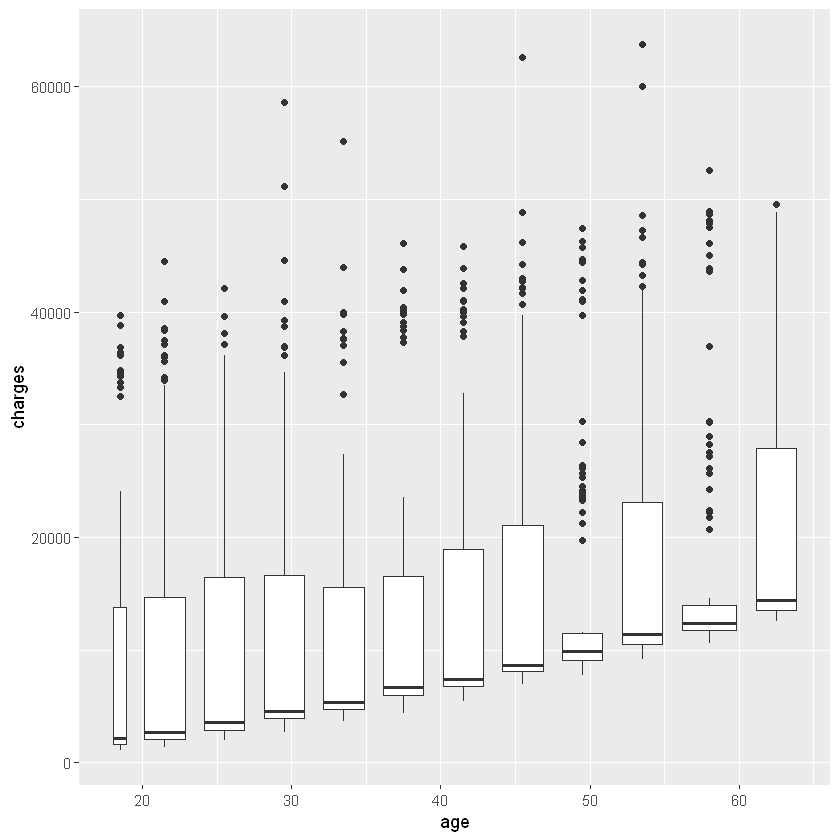

In [12]:
# age boxplot
ggplot(data = data, mapping = aes(x = age, y = charges)) +
  geom_boxplot()
# 5 age period boxplot
ggplot(data = data, mapping = aes(x = age, y = charges)) +
  geom_boxplot(mapping = aes(group = cut_width(age, 5)))
# cut number
ggplot(data = data, mapping = aes(x = age, y = charges)) + 
  geom_boxplot(mapping = aes(group = cut_number(age, 12)))

전체 boxplot을 볼때 20000이상이면 outlier지만 age를 세분화 하면 40대 기준으로 outlier는 10000 정도 부터 이다. 단순하게 iqr값만 가지고 이상치를 정의하면 안되겠다.

Warning message:
"Continuous x aesthetic -- did you forget aes(group=...)?"


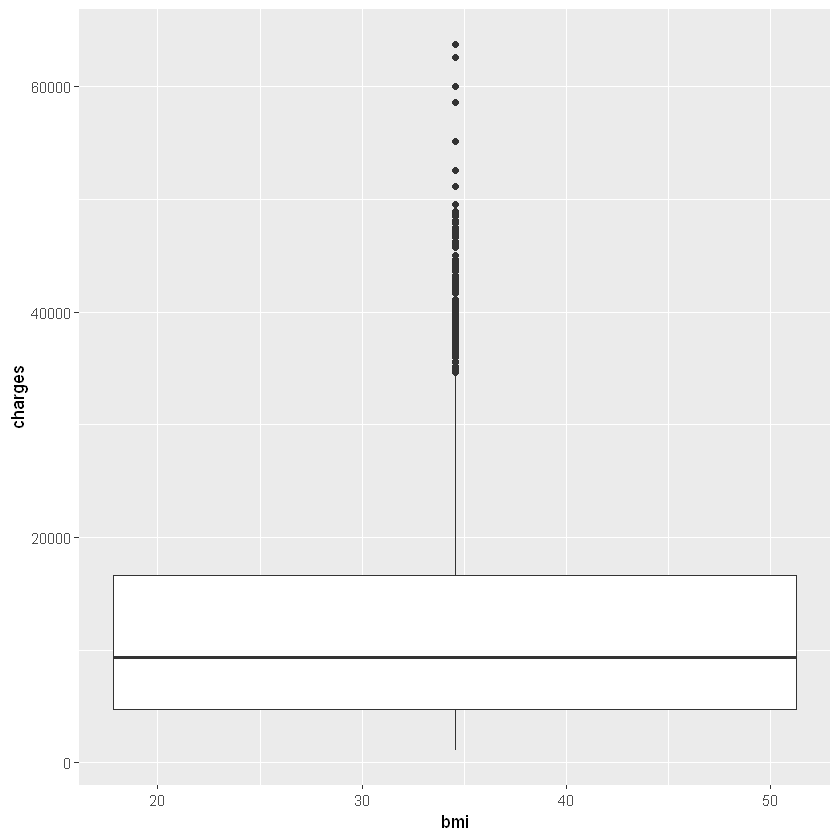

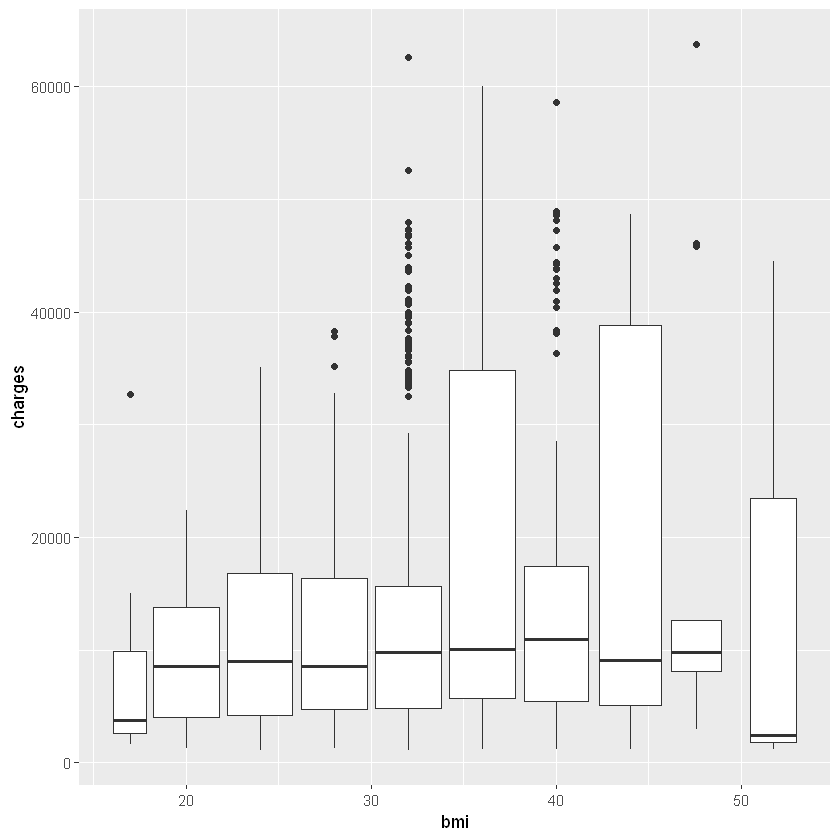

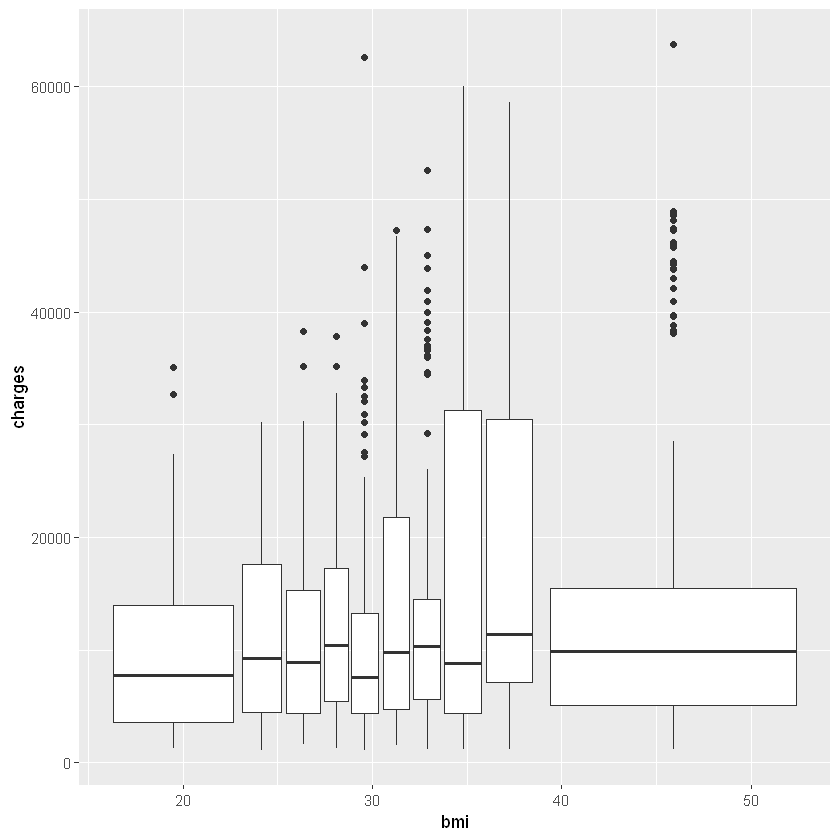

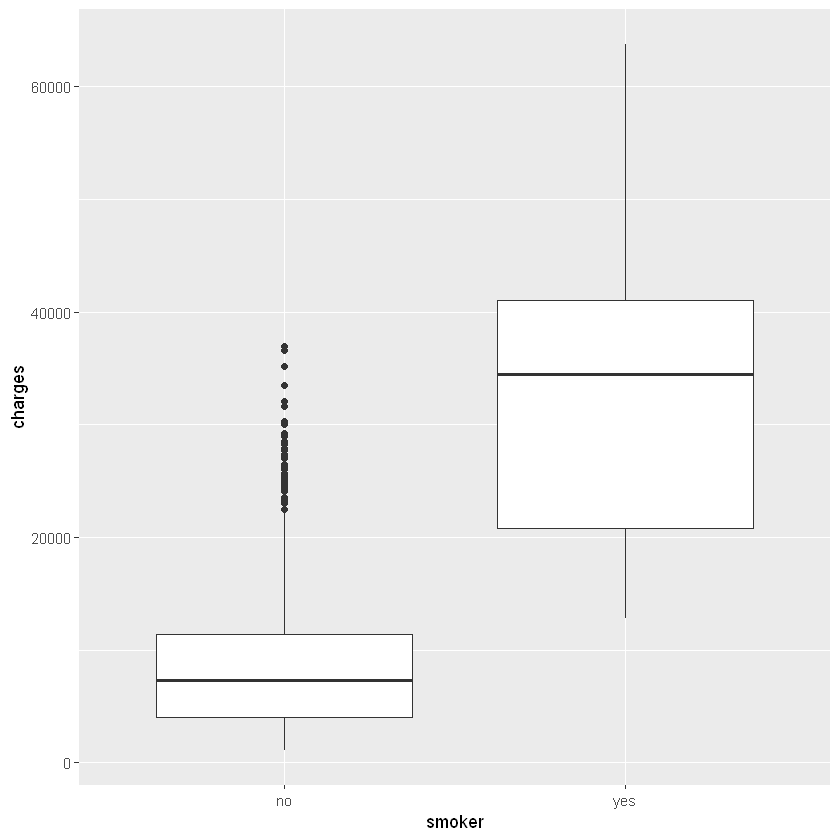

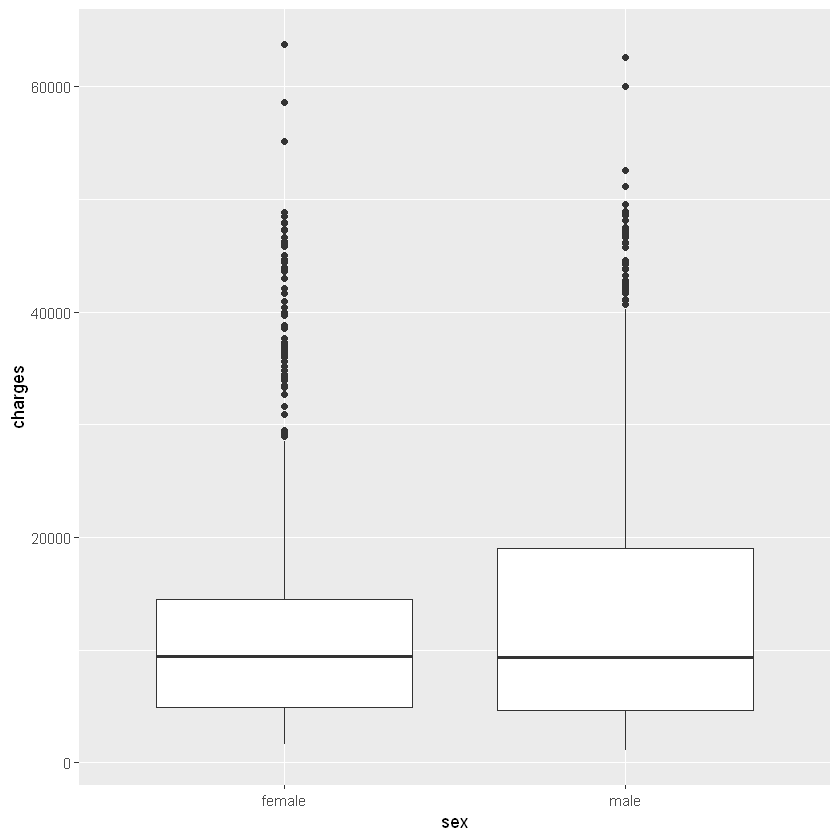

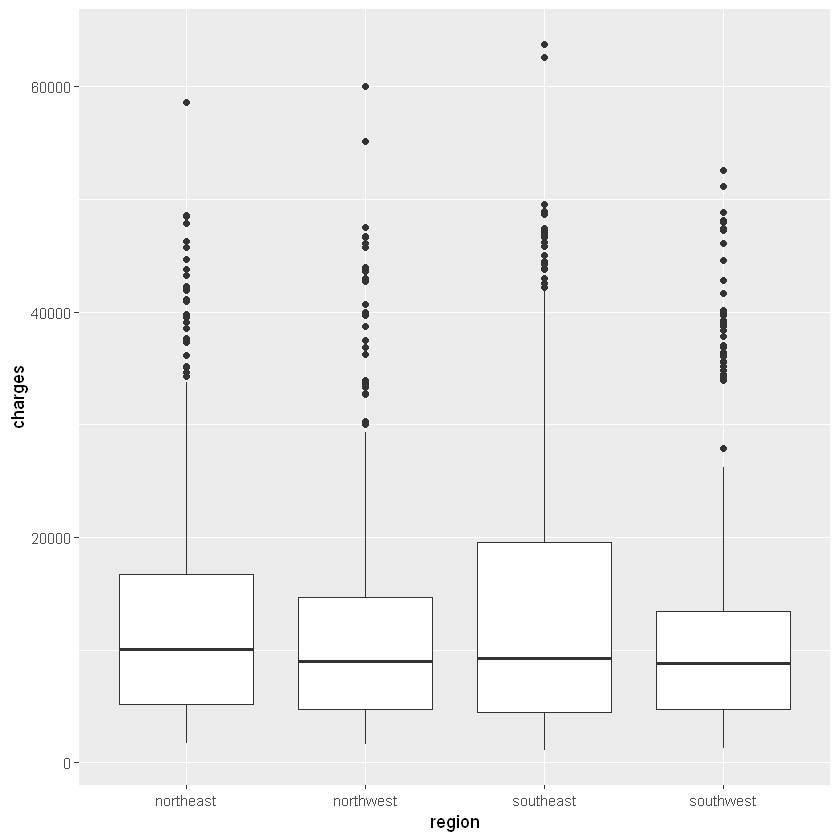

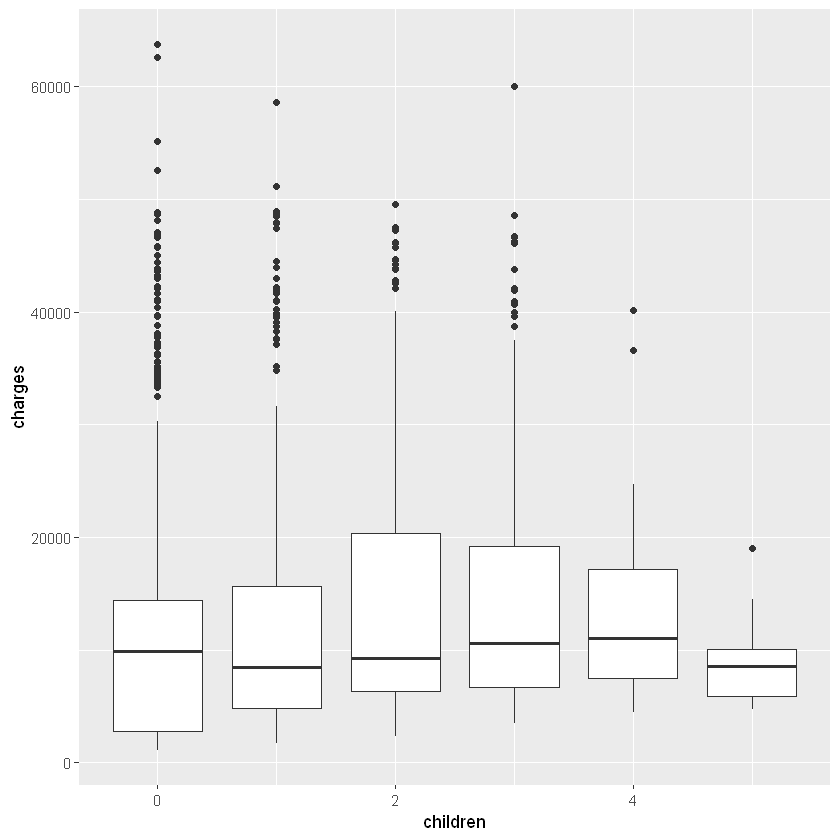

In [13]:
# bmi boxplot
ggplot(data = data, mapping = aes(x = bmi, y = charges)) +
  geom_boxplot()
# 5 bmi period boxplot
ggplot(data = data, mapping = aes(x = bmi, y = charges)) +
  geom_boxplot(mapping = aes(group = cut_width(bmi, 4)))
# cut number
ggplot(data = data, mapping = aes(x = bmi, y = charges)) + 
  geom_boxplot(mapping = aes(group = cut_number(bmi, 10)))

# smoker boxplot
ggplot(data = data, mapping = aes(x = smoker, y = charges)) +
  geom_boxplot()

# sex boxplot
ggplot(data = data, mapping = aes(x = sex, y = charges)) +
  geom_boxplot()

# region boxplot
ggplot(data = data, mapping = aes(x = region, y = charges)) +
  geom_boxplot()

# children boxplot
ggplot(data = data, mapping = aes(x =children, y = charges)) +
  geom_boxplot(mapping = aes(group = children ))

## Mean, Standard deviation, Skewness, Kurtosis

모든 변수에 대해 정규성을 가정할 수 없다고 mvn함수를 통해 알 수있다.

In [9]:
totalstat<-function(i){
    m = mean(i)
    sd = sqrt(var(i))
    kr = kurtosis(i)
    sk = skewness(i)
    return(c(m,sd,sk,kr))
}

statdf <- data.frame(matrix(0,nrow = 9,ncol = 4))
names(statdf)<-c("Mean", "Standard deviation", "Skewness","Kurtosis")
rownames(statdf)<-names(mlr_data)
j=1
for(i in c(1,2,3,4,5,6,7,8,9)){
  #print(data[[i]])
  if(is.numeric(mlr_data[[i]])){
    statdf[j,] <- totalstat( mlr_data[[i]] )
    j <- j+ 1
    }
}  
head(statdf,9)

,Mean,Standard deviation,Skewness,Kurtosis
,<dbl>,<dbl>,<dbl>,<dbl>
age,3.920703e+01,1.404996e+01,0.05561008,1.755079
bmi,3.066340e+01,6.098187e+00,0.28372857,2.944977
children,1.094918e+00,1.205493e+00,0.93732812,3.197217
charges,1.327042e+04,1.211001e+04,1.51417971,4.595821
sex,4.947683e-01,5.001596e-01,0.02092790,1.000438
smoker,2.047833e-01,4.036940e-01,1.46312353,3.140730
southeast,2.720478e-01,4.451808e-01,1.02447099,2.049541
southwest,2.428999e-01,4.289954e-01,1.19906309,2.437752
northeast,2.421525e-01,4.285463e-01,1.20380906,2.449156


In [10]:
mvn(mlr_data)

$multivariateNormality
             Test         Statistic              p value Result
1 Mardia Skewness  3293.36983811135                    0     NO
2 Mardia Kurtosis -5.83716975472766 5.30949928467805e-09     NO
3             MVN              <NA>                 <NA>     NO

$univariateNormality
          Test  Variable Statistic   p value Normality
1 Shapiro-Wilk    age       0.9447  <0.001      NO    
2 Shapiro-Wilk    bmi       0.9939  <0.001      NO    
3 Shapiro-Wilk children     0.8232  <0.001      NO    
4 Shapiro-Wilk  charges     0.8147  <0.001      NO    
5 Shapiro-Wilk    sex       0.6366  <0.001      NO    
6 Shapiro-Wilk  smoker      0.4950  <0.001      NO    
7 Shapiro-Wilk southeast    0.5562  <0.001      NO    
8 Shapiro-Wilk southwest    0.5324  <0.001      NO    
9 Shapiro-Wilk northeast    0.5317  <0.001      NO    

$Descriptives
             n         Mean      Std.Dev   Median      Min      Max       25th
age       1338 3.920703e+01 1.404996e+01   39.000   18.000    64.00   27.00000
bmi       1338 3.066340e+01 6.098187e+00   30.400   15.960    53.13   26.29625
children  1338 1.094918e+00 1.205493e+00    1.000    0.000     5.00    0.00000
charges   1338 1.327042e+04 1.211001e+04 9382.033 1121.874 63770.43 4740.28715
sex       1338 4.947683e-01 5.001596e-01    0.000    0.000     1.00    0.00000
smoker    1338 2.047833e-01 4.036940e-01    0.000    0.000     1.00    0.00000
southeast 1338 2.720478e-01 4.451808e-01    0.000    0.000     1.00    0.00000
southwest 1338 2.428999e-01 4.289954e-01    0.000    0.000     1.00    0.00000
northeast 1338 2.421525e-01 4.285463e-01    0.000    0.000     1.00    0.00000
                 75th       Skew    Kurtosis
age          51.00000 0.05554775 -1.24754314
bmi          34.69375 0.28341055 -0.05942352
children      2.00000 0.93627750  0.19244011
charges   16639.91251 1.51248252  1.58895424
sex           1.00000 0.02090444 -2.00105689
smoker        0.00000 1.46148357  0.13603757
southeast     1.00000 1.02332269 -0.95352164
southwest     0.00000 1.19771910 -0.56589022
northeast     0.00000 1.20245975 -0.55450330

In [11]:
result<-mvn(mlr_data)

In [12]:
result$multivariateOutliers

NULL

# mahalanobis distance
단순히 iqr를 사용하여 이상치를 정의하기 어려우니 다변량 데이터임으로, 변수간 공분산을 고려한 마할나노비스 거리를 활용해 이상치 정의에 활용하겠다.

16.91898

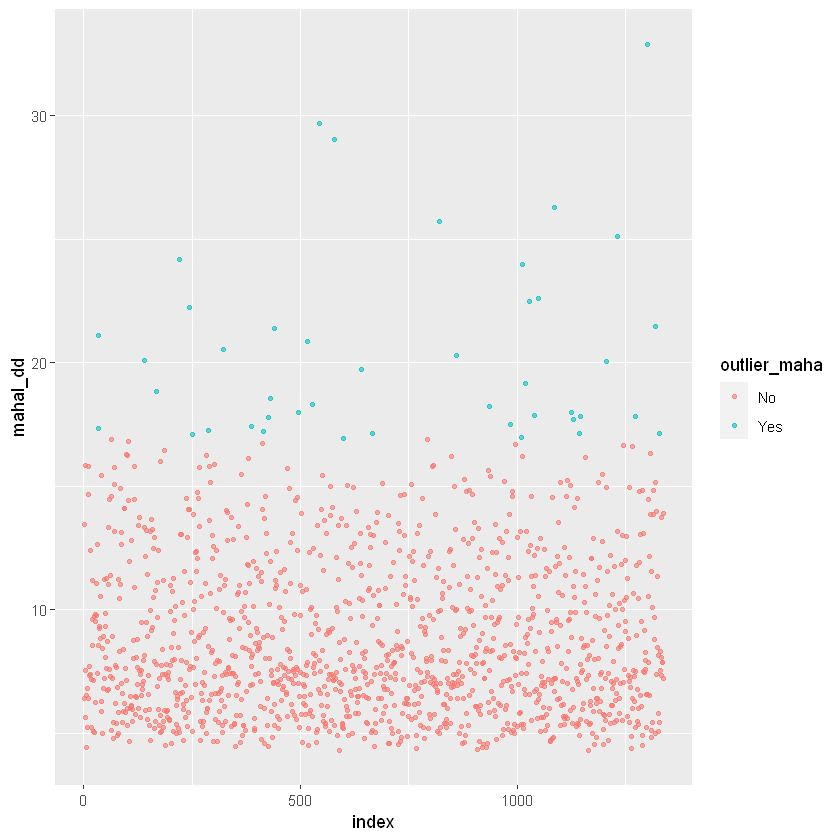

In [16]:
# Mahalanobis Distance 거리 구하기
mahal_dd<-mahalanobis(mlr_data,colMeans(mlr_data),cov(mlr_data))
mahal_df <- data.frame(mahal_dd)


# Mahalanobis Outliers : find threshold by chi square distribution 95%
cutoff <- qchisq(p = 0.95 , df = ncol(mlr_data))
cat(cutoff)
mahal_df$outlier_maha <- "No"
mahal_df$outlier_maha[mahal_df$mahal_dd > cutoff] <- "Yes"
mahal_df$index <- c(1:1338)

# Scatterplot with Maha Outliers
ggplot(mahal_df, aes(x=index, y = mahal_dd, color = outlier_maha)) +
  geom_point(size = 1, alpha = 0.6)

# define outlier

### mahalanobis 95%밖에 있으면서, iqr 밖에 있는 데이터들  ->  mahalanobis 95% 안 union iqr 안

In [17]:
# mahalanobis 95%
ml_idx<-which(mahal_df$outlier_maha == "No")

# IQR 에 해당하는 영역- charges

test <- mlr_data
test$index <- c(1:nrow(mlr_data))

quantiles <- quantile(test$charges, probs = c(.25, .75))
cat(quantiles)

iqr_df<-test %>% filter(between(charges,quantiles[1], quantiles[2]))

outlier_idx<-union(ml_idx,iqr_df$index)

out_data<-mlr_data %>% slice(outlier_idx)
str(out_data)

4740.287 16639.91'data.frame':	1305 obs. of  9 variables:
 $ age      : int  19 18 28 33 32 31 46 37 37 60 ...
 $ bmi      : num  27.9 33.8 33 22.7 28.9 ...
 $ children : int  0 1 3 0 0 0 1 3 2 0 ...
 $ charges  : num  16885 1726 4449 21984 3867 ...
 $ sex      : num  1 0 0 0 0 1 1 1 0 1 ...
 $ smoker   : num  1 0 0 0 0 0 0 0 0 0 ...
 $ southeast: num  0 1 1 0 0 1 1 0 0 0 ...
 $ southwest: num  1 0 0 0 0 0 0 0 0 0 ...
 $ northeast: num  0 0 0 0 0 0 0 0 1 0 ...


# correlation plot

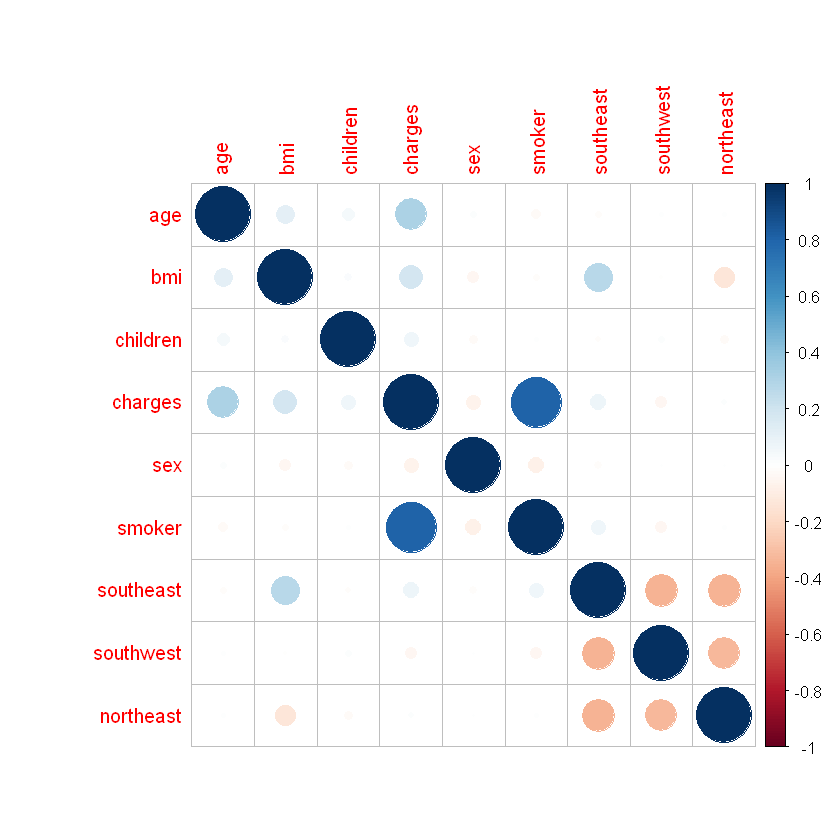

In [18]:
corrplot(cor(out_data))

# make linear model ( use all attributes )


Call:
lm(formula = charges ~ ., data = trn_data)

Coefficients:
(Intercept)          age          bmi     children          sex       smoker  
   -12510.4        256.9        331.5        308.2        316.6      23763.8  
  southeast    southwest    northeast  
     -236.5         13.0        613.7  



Call:
lm(formula = charges ~ ., data = trn_data)

Residuals:
   Min     1Q Median     3Q    Max 
-11606  -2849   -878   1514  29952 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -12510.42    1178.07 -10.619   <2e-16 ***
age            256.90      14.12  18.199   <2e-16 ***
bmi            331.49      33.35   9.940   <2e-16 ***
children       308.23     163.27   1.888   0.0594 .  
sex            316.64     394.81   0.802   0.4228    
smoker       23763.82     492.34  48.268   <2e-16 ***
southeast     -236.48     565.81  -0.418   0.6761    
southwest       13.00     568.23   0.023   0.9817    
northeast      613.67     563.71   1.089   0.2766    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6023 on 928 degrees of freedom
Multiple R-squared:  0.7499,	Adjusted R-squared:  0.7477 
F-statistic: 347.8 on 8 and 928 DF,  p-value: < 2.2e-16


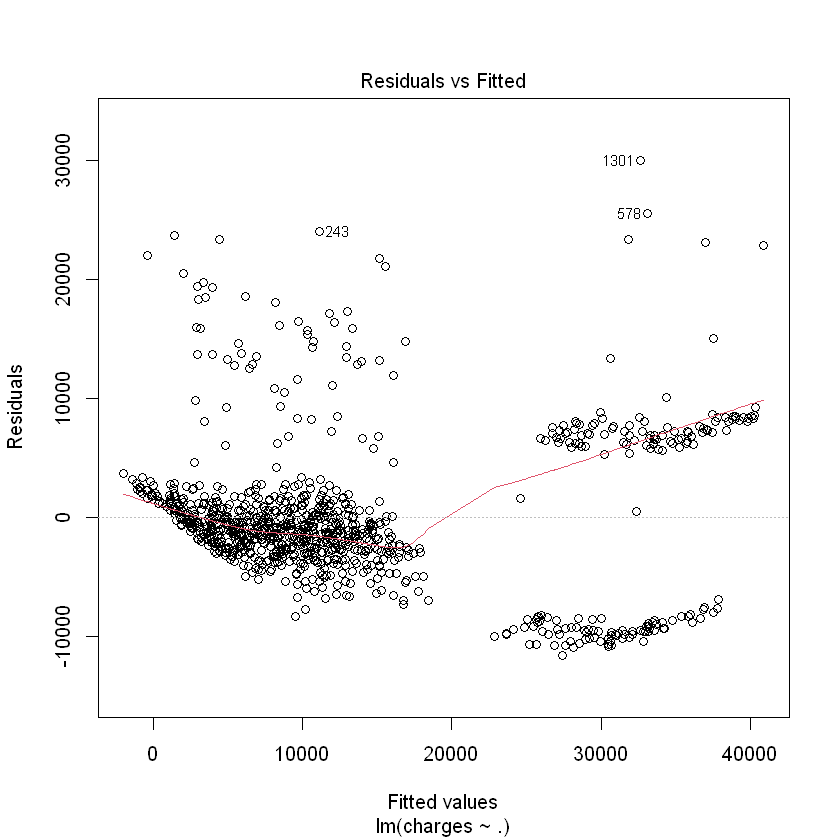

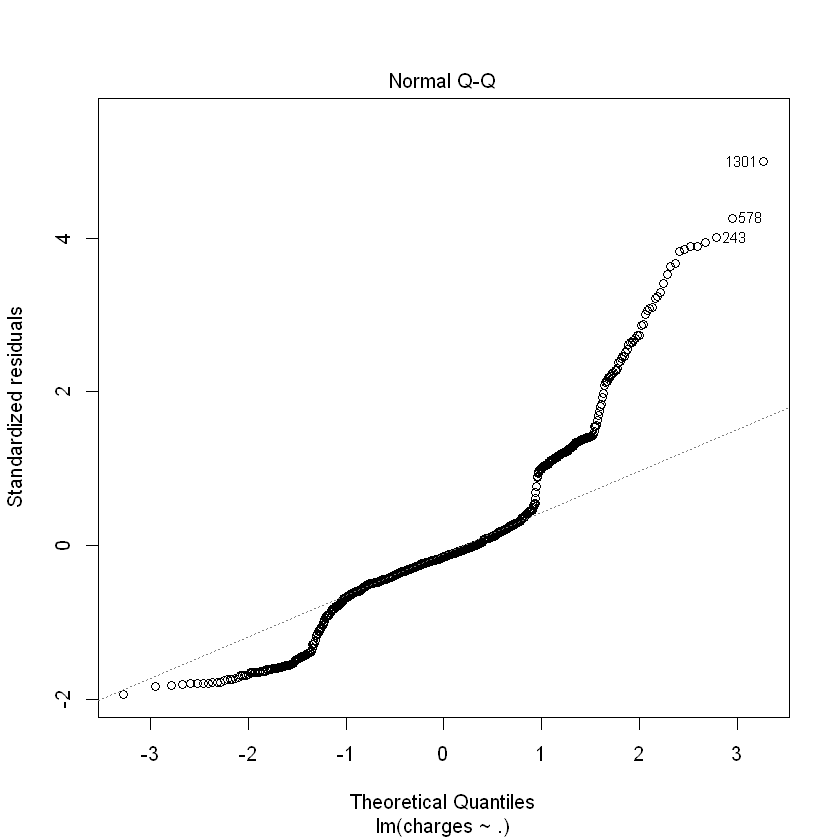

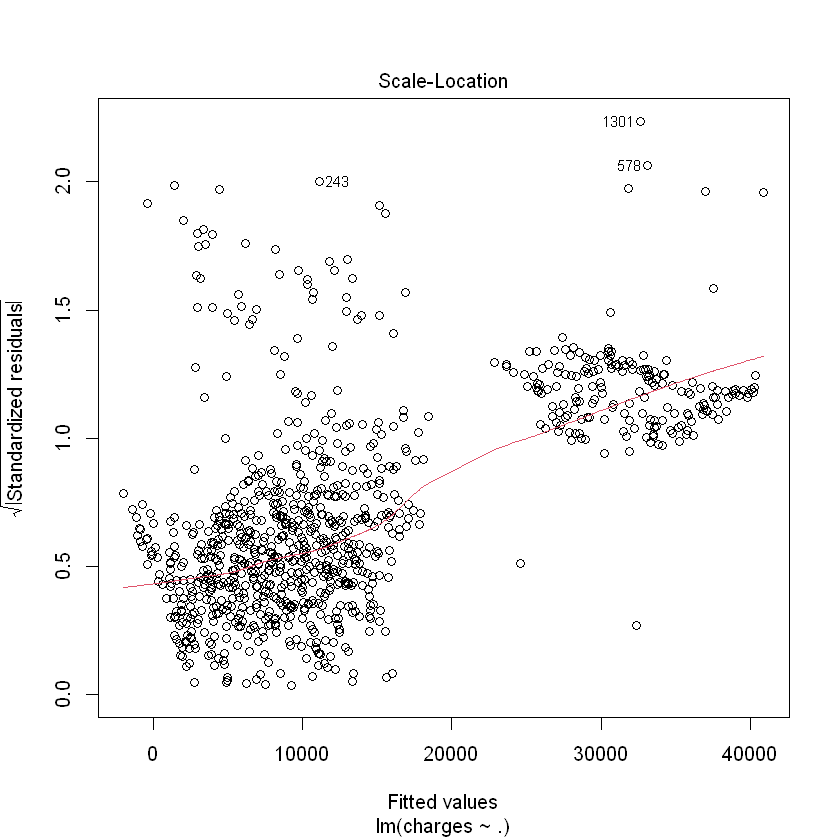

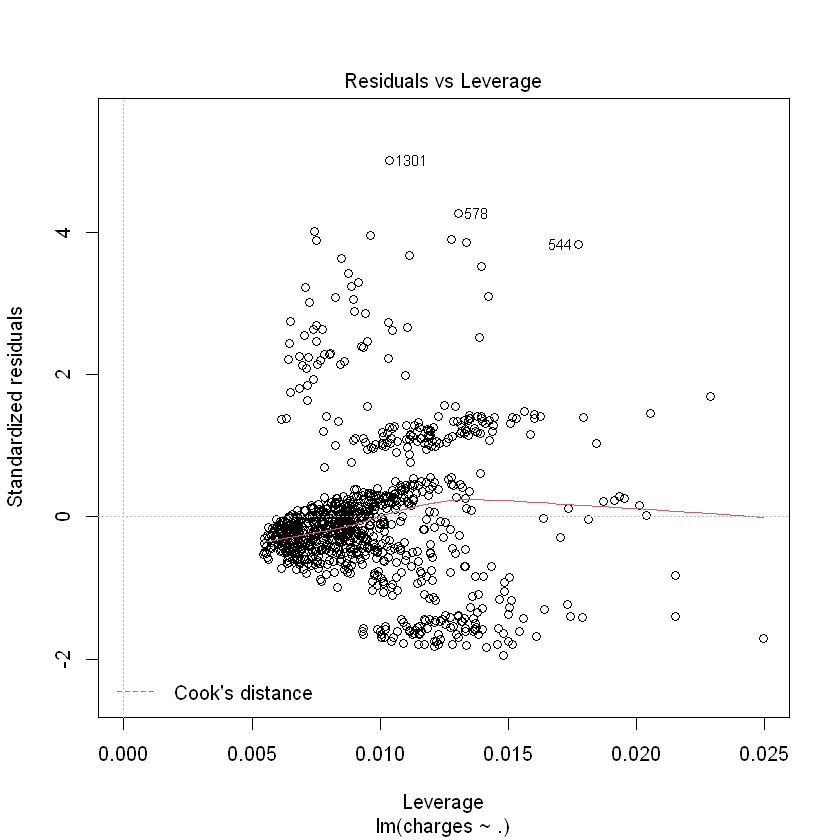

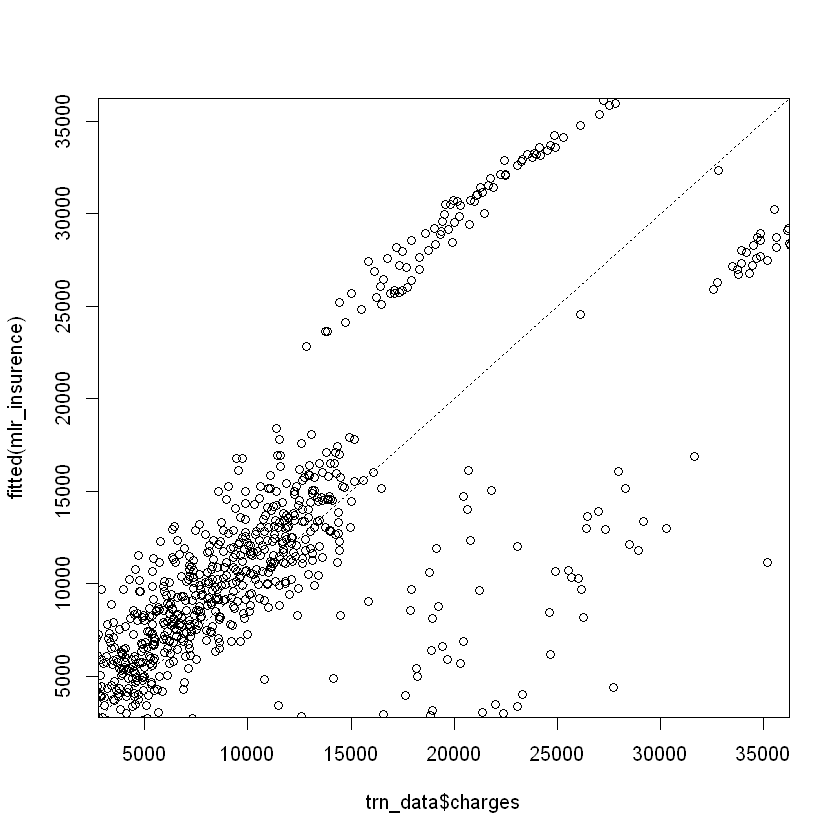

[1] 1.275848

[1] 6.056976

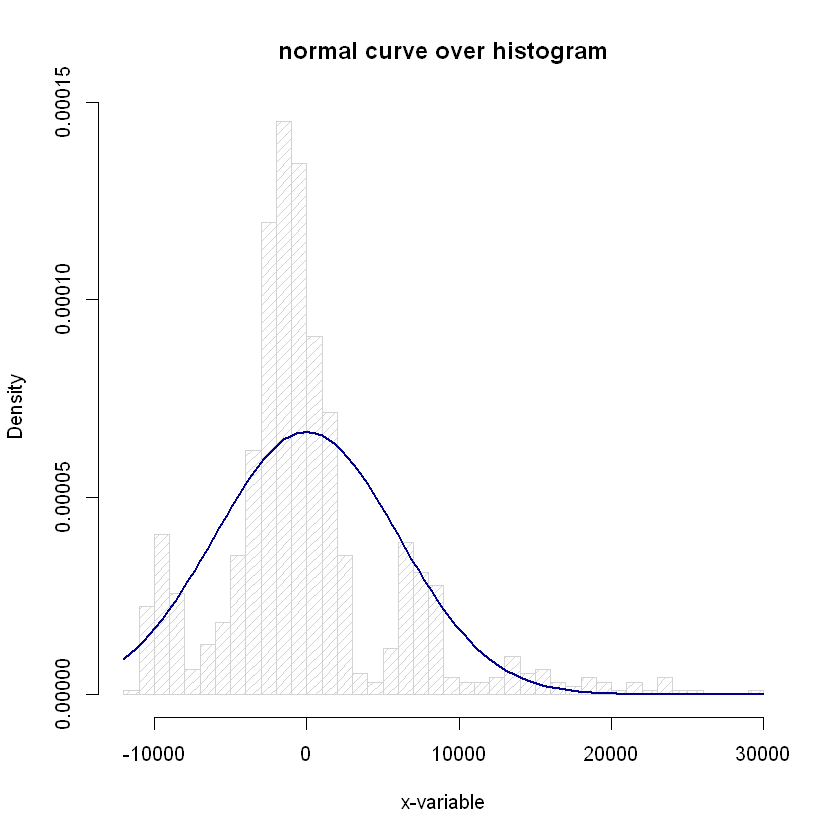

In [19]:
mlr_insurence <- lm(charges ~ ., data = trn_data)
mlr_insurence
summary(mlr_insurence)
plot(mlr_insurence)

# Plot the result
plot(trn_data$charges, fitted(mlr_insurence), 
     xlim = c(4000,35000), ylim = c(4000,35000))
abline(0,1,lty=3)

# normality test of residuals
resid <- resid(mlr_insurence)

m <- mean(resid)
std <- sqrt(var(resid))

hist(resid, density=20, breaks=50, prob=TRUE, 
     xlab="x-variable", main="normal curve over histogram")

curve(dnorm(x, mean=m, sd=std), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

skewness(resid)
kurtosis(resid)

# Performance Measure
mlr_haty <- predict(mlr_insurence, newdata = val_data)

perf_mat <- perf_eval_reg(val_data$charges, mlr_haty)
names(perf_mat)<-c("RMSE", "MAE", "MAPE")

In [20]:
perf_mat

RMSE        MAE       MAPE 
6182.65452 4305.73904   41.33498

# make linear model ( use only age, bmi, smoker )


Call:
lm(formula = charges ~ age + bmi + smoker, data = trn_data)

Coefficients:
(Intercept)          age          bmi       smoker  
   -11729.1        260.4        320.5      23776.5  



Call:
lm(formula = charges ~ age + bmi + smoker, data = trn_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-12305.2  -2892.1   -912.2   1486.0  29100.3 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -11729.06    1105.02 -10.614   <2e-16 ***
age            260.36      14.05  18.526   <2e-16 ***
bmi            320.45      32.18   9.957   <2e-16 ***
smoker       23776.52     490.87  48.437   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6027 on 933 degrees of freedom
Multiple R-squared:  0.7482,	Adjusted R-squared:  0.7474 
F-statistic:   924 on 3 and 933 DF,  p-value: < 2.2e-16


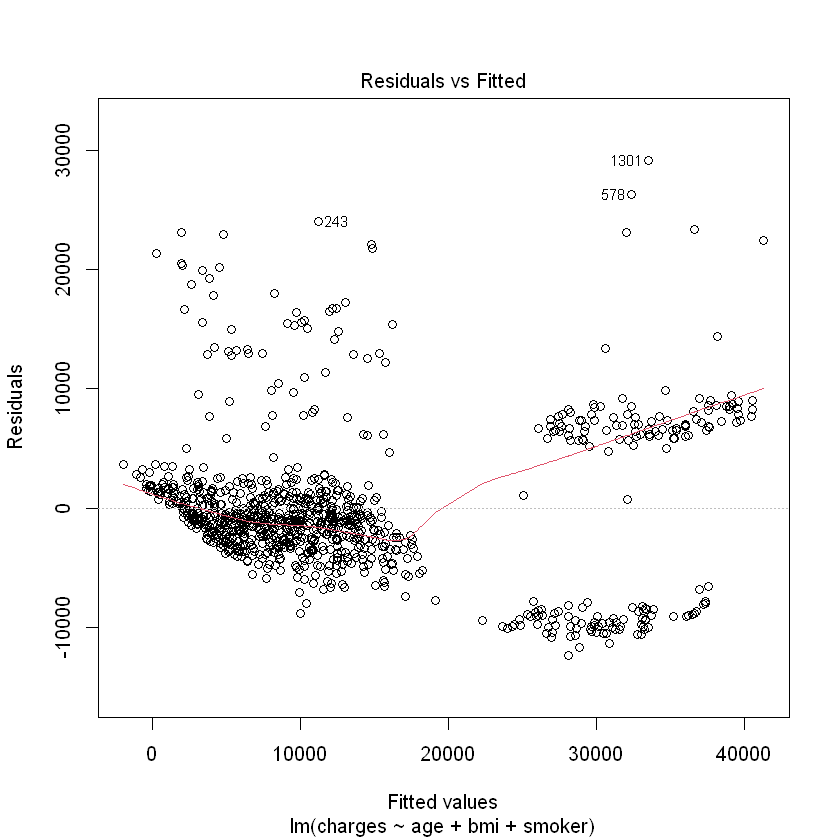

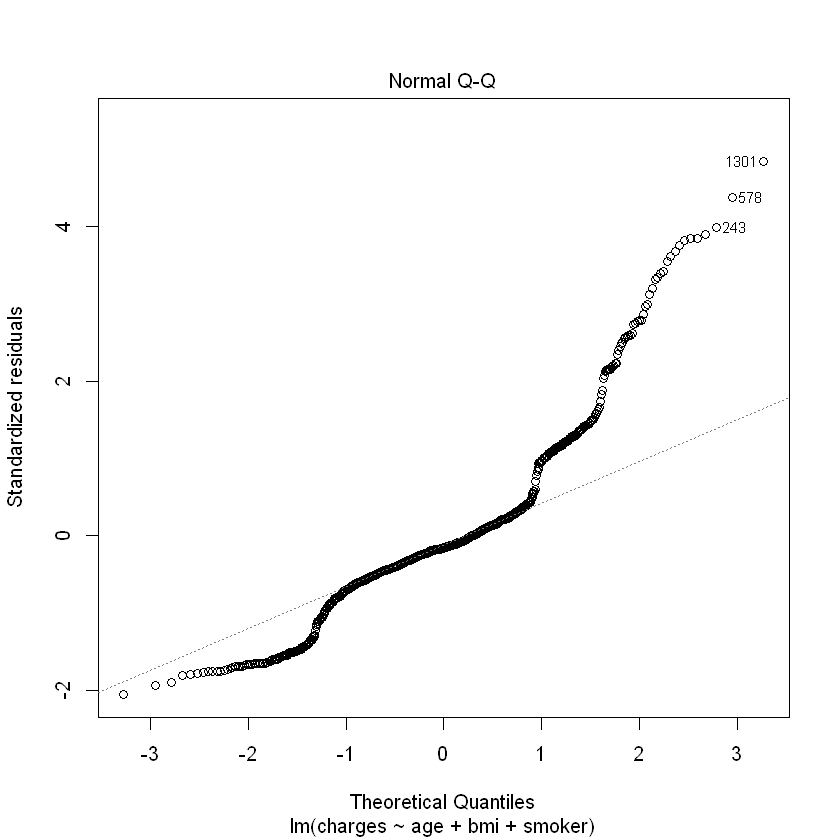

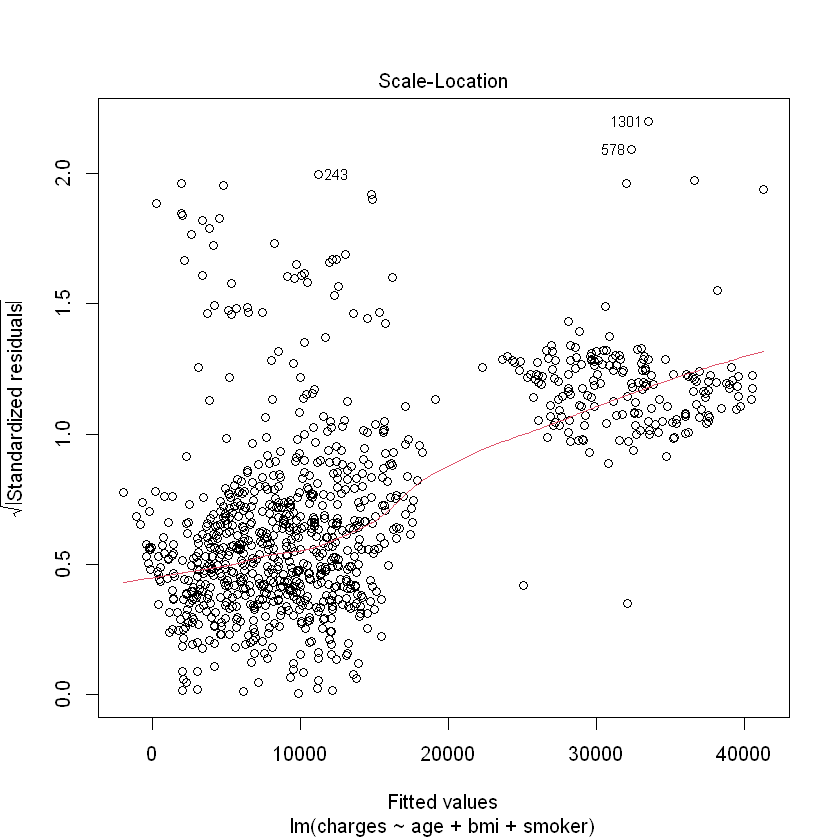

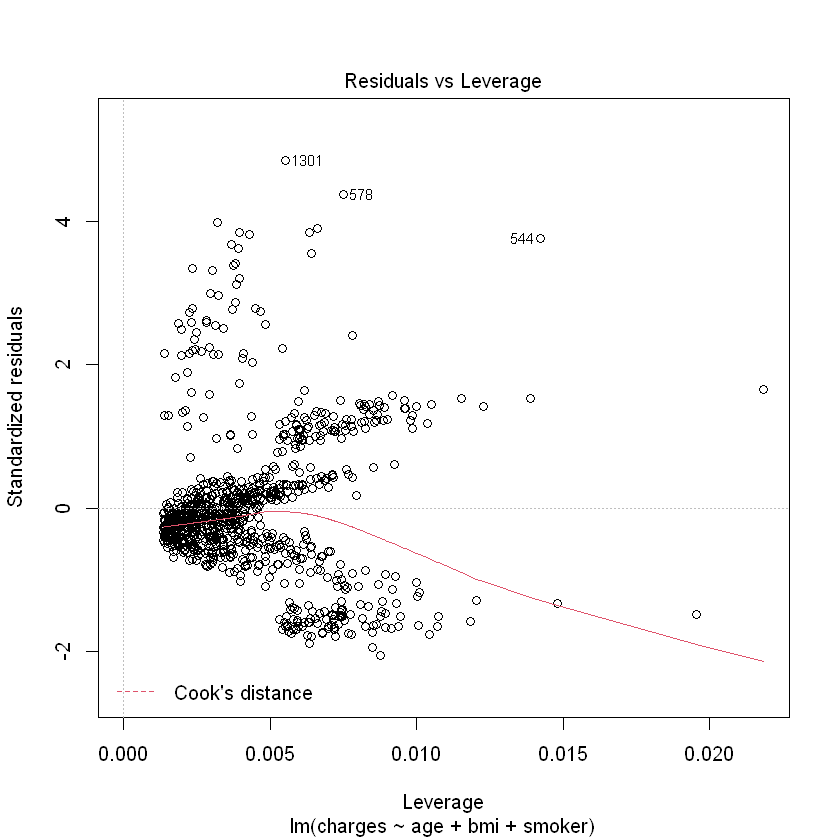

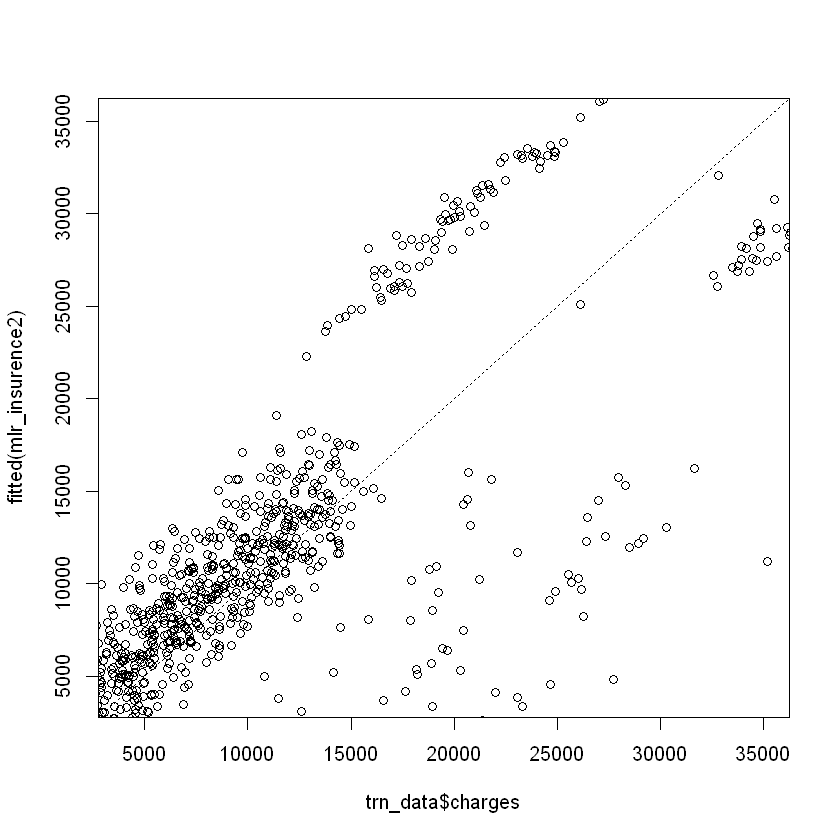

[1] 1.272122

[1] 5.998338

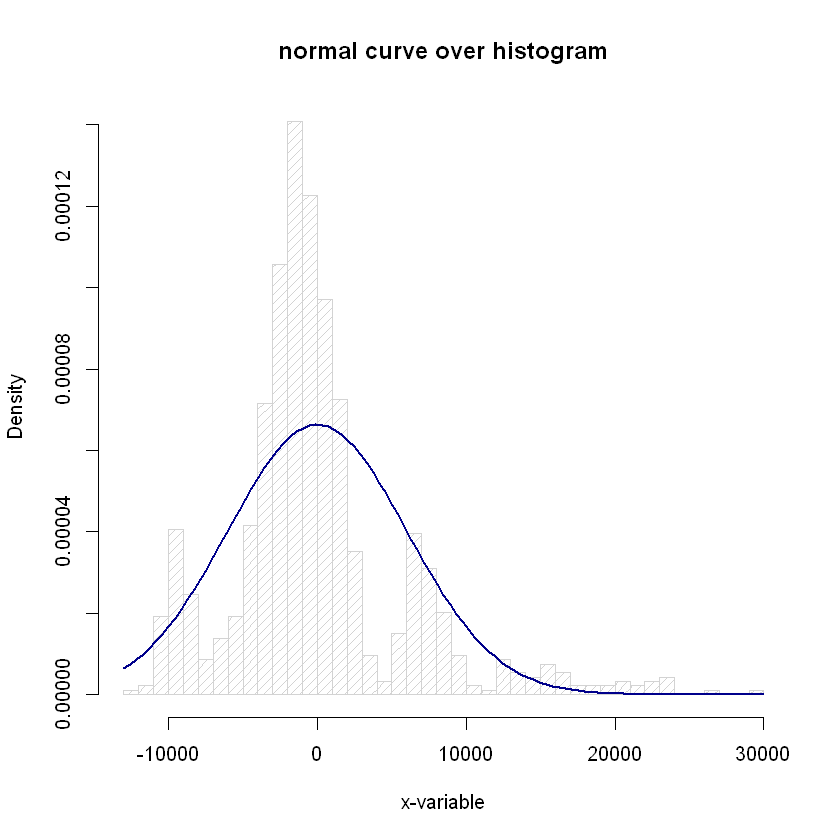

In [21]:
mlr_insurence2 <- lm(charges ~ age + bmi+ smoker, data = trn_data)
mlr_insurence2
summary(mlr_insurence2)
plot(mlr_insurence2)

# Plot the result
plot(trn_data$charges, fitted(mlr_insurence2), 
     xlim = c(4000,35000), ylim = c(4000,35000))
abline(0,1,lty=3)

# normality test of residuals
resid2 <- resid(mlr_insurence2)

m <- mean(resid2)
std <- sqrt(var(resid2))

hist(resid2, density=20, breaks=50, prob=TRUE, 
     xlab="x-variable", main="normal curve over histogram")

curve(dnorm(x, mean=m, sd=std), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

skewness(resid2)
kurtosis(resid2)

# Performance Measure
mlr_haty2 <- predict(mlr_insurence2, newdata = val_data)

perf_mat2 <- perf_eval_reg(val_data$charges, mlr_haty)
names(perf_mat2)<-c("RMSE", "MAE", "MAPE")

In [22]:
perf_mat2

RMSE        MAE       MAPE 
6182.65452 4305.73904   41.33498

# random forest regression (use all attributes )

In [23]:
fitControl <- trainControl(method = "repeatedcv",number = 10, repeats = 30)

rf_fit <- train(charges~.,data = trn_data, 
                method = "rf", 
                trControl = fitControl)
rf_fit


rf_haty<- predict(rf_fit,newdata = val_data) 

perf_mat3 <- perf_eval_reg(val_data$charges, rf_haty)
names(perf_mat3)<-c("RMSE", "MAE", "MAPE")
perf_mat3

Random Forest 

937 samples
  8 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 30 times) 
Summary of sample sizes: 844, 843, 842, 842, 844, 844, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
  2     5198.512  0.8402267  3481.731
  5     4629.717  0.8469078  2557.035
  8     4735.025  0.8403642  2610.189

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 5.

RMSE        MAE       MAPE 
4732.39884 2634.49208   31.59716

In [25]:
summary(rf_fit)

                Length Class      Mode     
call              4    -none-     call     
type              1    -none-     character
predicted       937    -none-     numeric  
mse             500    -none-     numeric  
rsq             500    -none-     numeric  
oob.times       937    -none-     numeric  
importance        8    -none-     numeric  
importanceSD      0    -none-     NULL     
localImportance   0    -none-     NULL     
proximity         0    -none-     NULL     
ntree             1    -none-     numeric  
mtry              1    -none-     numeric  
forest           11    -none-     list     
coefs             0    -none-     NULL     
y               937    -none-     numeric  
test              0    -none-     NULL     
inbag             0    -none-     NULL     
xNames            8    -none-     character
problemType       1    -none-     character
tuneValue         1    data.frame list     
obsLevels         1    -none-     logical  
param             0    -none-   

# random forest regression (use age bmi smoker)

In [24]:
rf_fit2 <- train(charges~age+bmi+smoker,data = trn_data, 
                method = "rf", 
                trControl = fitControl)
rf_fit2
rf_haty<- predict(rf_fit2,newdata = val_data) 

perf_mat4 <- perf_eval_reg(val_data$charges, rf_haty)
names(perf_mat4)<-c("RMSE", "MAE", "MAPE")
perf_mat4

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Random Forest 

937 samples
  3 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 30 times) 
Summary of sample sizes: 843, 845, 843, 843, 844, 842, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
  2     4842.098  0.8327728  2703.496
  3     4976.727  0.8241713  2783.398

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.

RMSE        MAE       MAPE 
4982.66311 2824.81132   34.87835

In [27]:
summary(rf_fit2)

                Length Class      Mode     
call              4    -none-     call     
type              1    -none-     character
predicted       937    -none-     numeric  
mse             500    -none-     numeric  
rsq             500    -none-     numeric  
oob.times       937    -none-     numeric  
importance        3    -none-     numeric  
importanceSD      0    -none-     NULL     
localImportance   0    -none-     NULL     
proximity         0    -none-     NULL     
ntree             1    -none-     numeric  
mtry              1    -none-     numeric  
forest           11    -none-     list     
coefs             0    -none-     NULL     
y               937    -none-     numeric  
test              0    -none-     NULL     
inbag             0    -none-     NULL     
xNames            3    -none-     character
problemType       1    -none-     character
tuneValue         1    data.frame list     
obsLevels         1    -none-     logical  
param             0    -none-   